In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

from model import Opt_GMM_Mapper
from model import Trainer
from model import Soft_Mapper

from scripts.analysis_msbb import analysis_braak
torch.manual_seed(0) #fix seed
np.random.seed(42)

In [2]:
def Lor_distance(X, c): #X: n*dim c: 1*dim
    # centering
    X = X-c
    # add x_0
    x0 =  torch.sqrt(torch.norm(X, p=2, dim=1)**2 + 1)
    X = torch.cat((x0.unsqueeze(1), X), dim=-1)

    g = torch.eye(X.size()[1],dtype=float)
    g[0,0] = -1
    term1 = torch.matmul(X,g)
    r = torch.matmul(term1, X.T)
    dis = torch.acosh(-r)
    #dis.fill_diagonal_(fill_value=0)
    return dis

def mean_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))
    dis_list = torch.stack(dis_list)
    #dis = torch.mean(dis_list, dim=0)
    dis = torch.mean(dis_list, dim=0) #/torch.std(dis_list, dim=0)
    dis.fill_diagonal_(0.)
    return dis

def matrix_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))

    dis_list = torch.stack(dis_list) #n*n*n
    n = dis_list.shape[0]
    distance_matrix = torch.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            distance = torch.norm(dis_list[i] - dis_list[j], p=2)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix


# 44

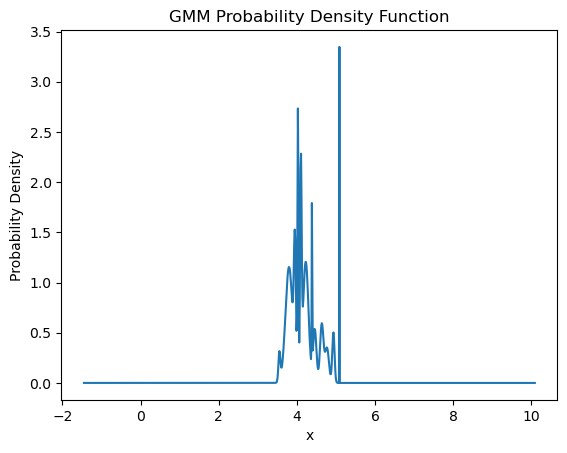

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


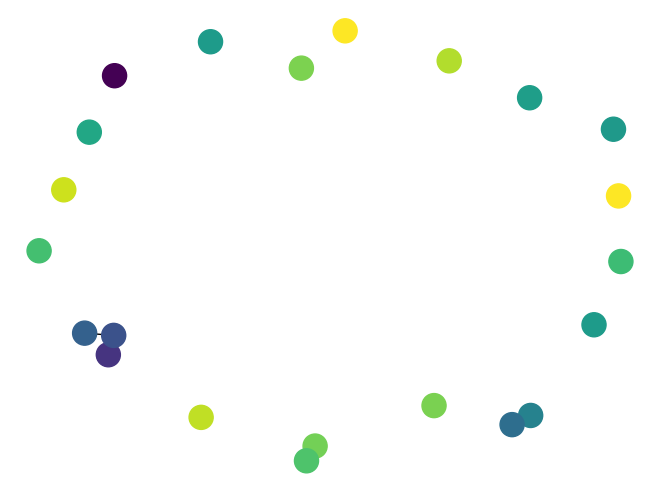

100%|██████████| 500/500 [00:10<00:00, 46.79it/s]

loss: -1.4154316030475464
topo_loss: -3.5878151914324063
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


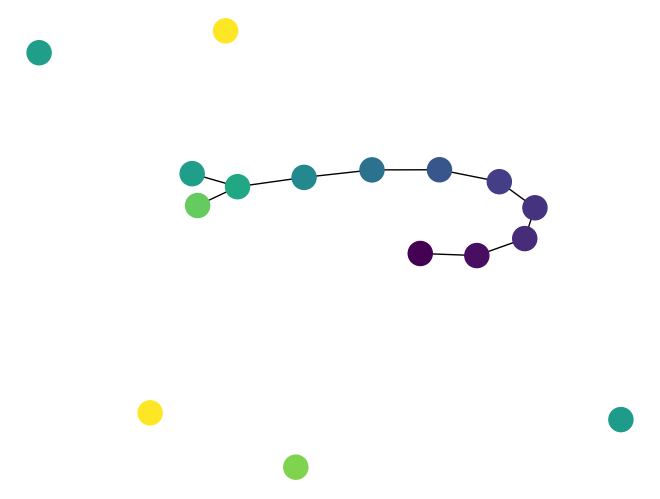

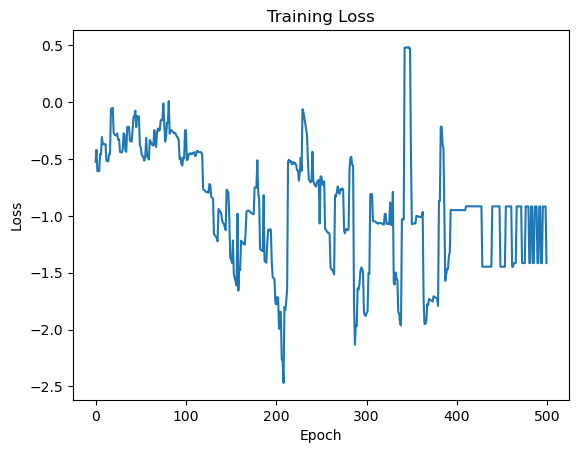

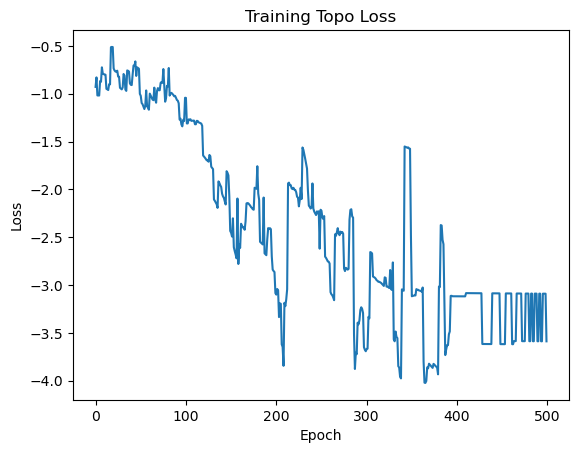

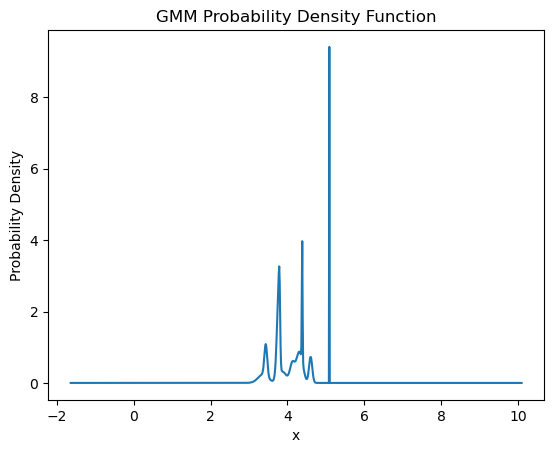

222


AttributeError: 'NoneType' object has no attribute 'size'

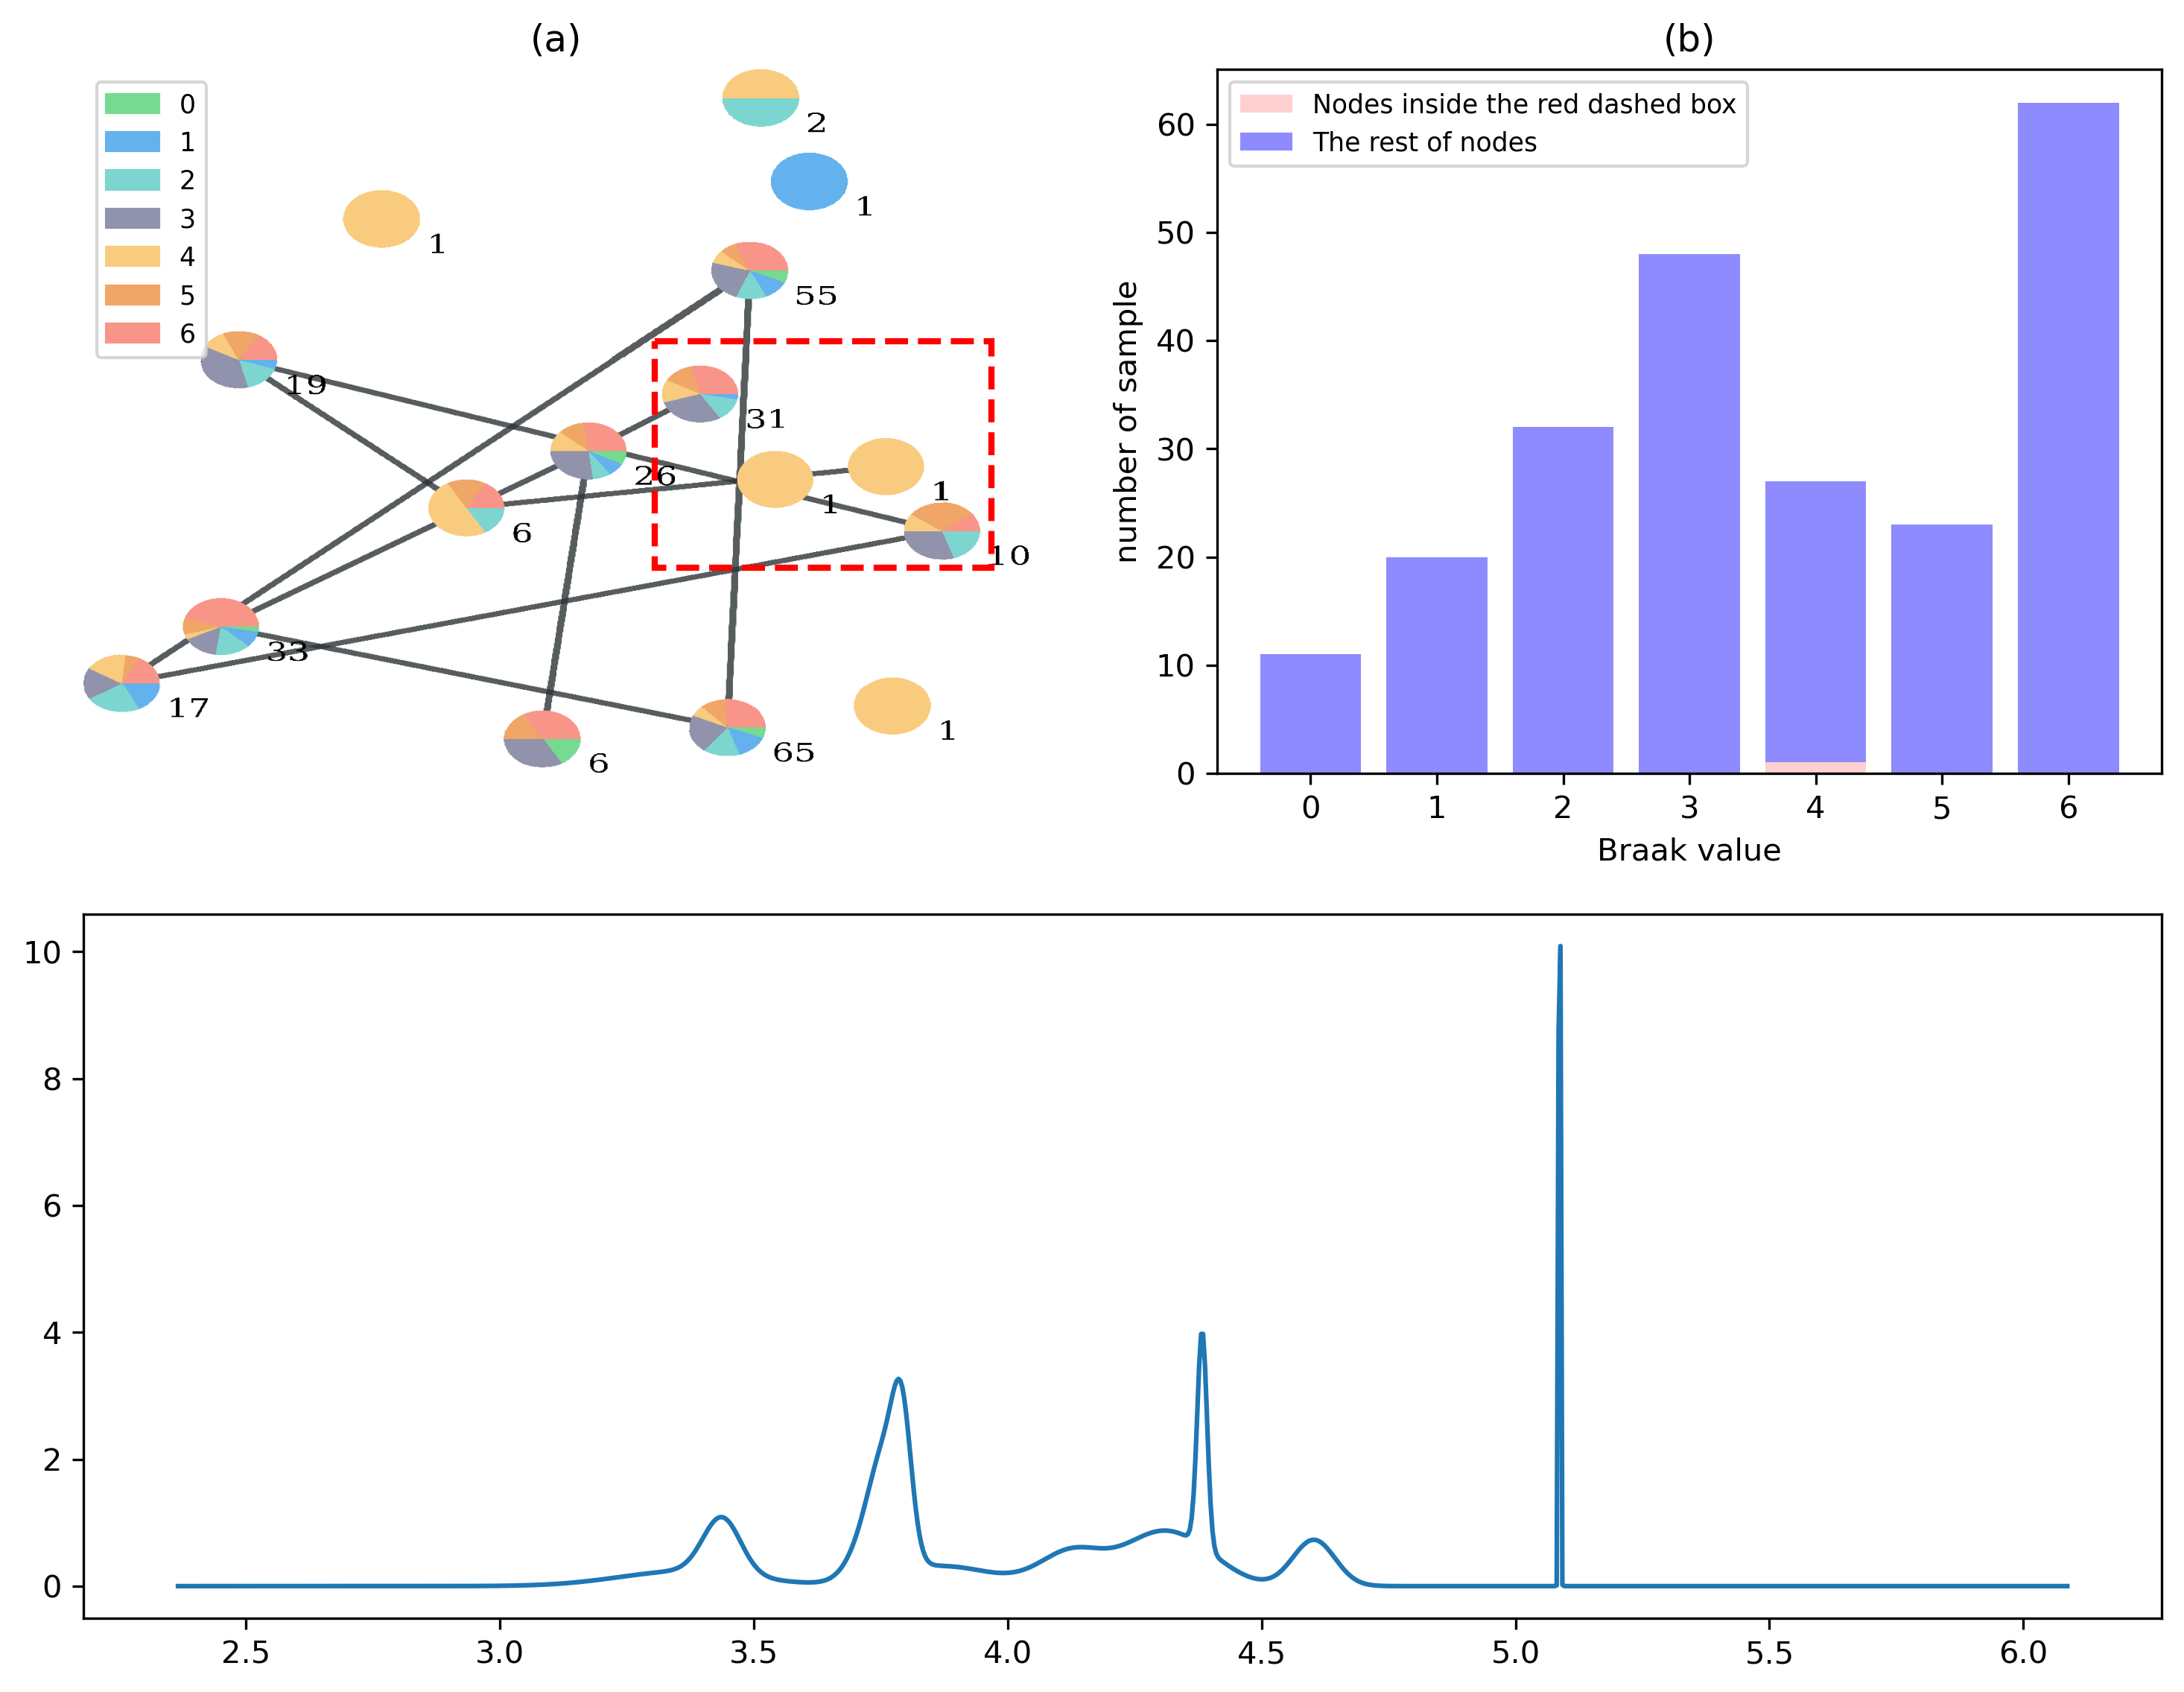

In [3]:
data_path = "data/44_top_gene.csv"
df = pd.read_csv(data_path,index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)
dis_matrix = mean_lor_distance(data)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 500 
l1 = 1
l2 = 1

cl = AgglomerativeClustering(distance_threshold=3.20, linkage='single',
                        metric='precomputed', n_clusters=None)

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=395, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
'''good_nodes = [10,4,16,13,9,5] 
pos_list = [[-8.77892714,  2.49193969], [-1.91190975, 11.24213662], [-12.27355404,  10.83751617], 
            [-4.13226413, 11.63114076], [-2,  6.94124777], [-3.82837833,  3.41902993], 
            [-7.64123319,  7.68353015], [-6,  6.65901699], [-3.68085897,  0.31738571], 
            [-4.5, 5.63655453], [-1.25, 8.1], [-6.61850381, 11.83334516], 
            [-3.02781267,  1.81900825], [-3.48943319,  7.17204177], [-10.94111472,   9.81616118], 
            [-10.69904875,   5.02340486], [-2.73536901,  5.53467267], [-4.49096918,  1.71719959], 
            [-9.37400673,  8.7422879 ]]'''
good_nodes = [1] 
pos_list = [[-8.77892714,  2.49193969], [-1.91190975, 11.24213662], [-12.27355404,  10.83751617], 
            [-4.13226413, 11.63114076], [-2,  6.94124777], [-3.82837833,  3.41902993], 
            [-7.64123319,  7.68353015], [-6,  6.65901699], [-3.68085897,  0.31738571], 
            [-4.5, 5.63655453], [-1.25, 8.1], [-6.61850381, 11.83334516], 
            [-3.02781267,  1.81900825], [-3.48943319,  7.17204177], [-10.94111472,   9.81616118], 
            [-10.69904875,   5.02340486], [-2.73536901,  5.53467267], [-4.49096918,  1.71719959], 
            [-9.37400673,  8.7422879 ]]
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, 
               (3.2,5.2),(-8, 6), pos_list = pos_list, rect_pos=(660,420,390,350)
               , text_pos=[0.,-0.5],name = "figures/44.eps")

# 36

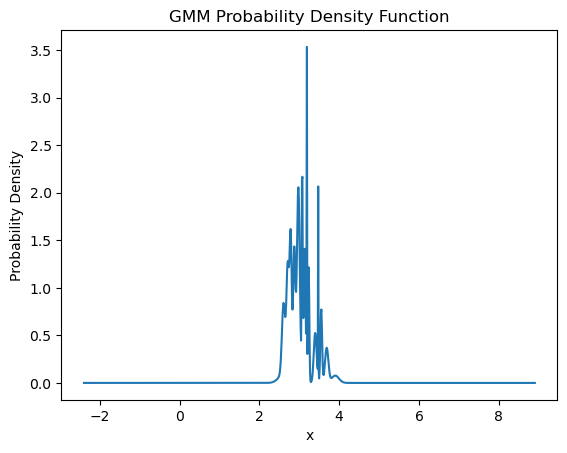

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


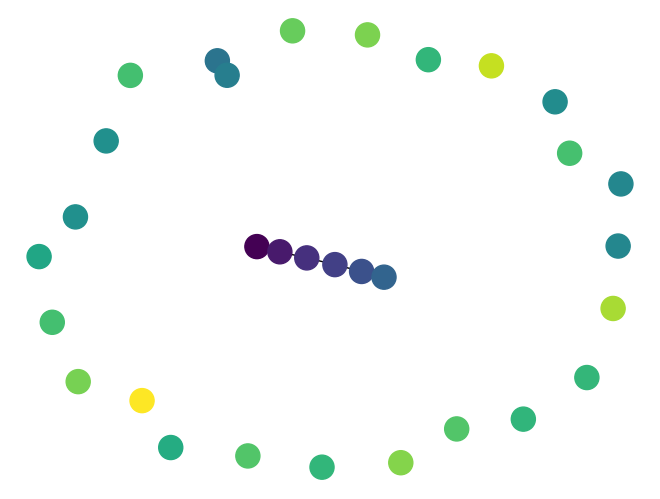

100%|██████████| 500/500 [00:13<00:00, 37.36it/s]


loss: -3.267951006032038
topo_loss: -4.726876166656767
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


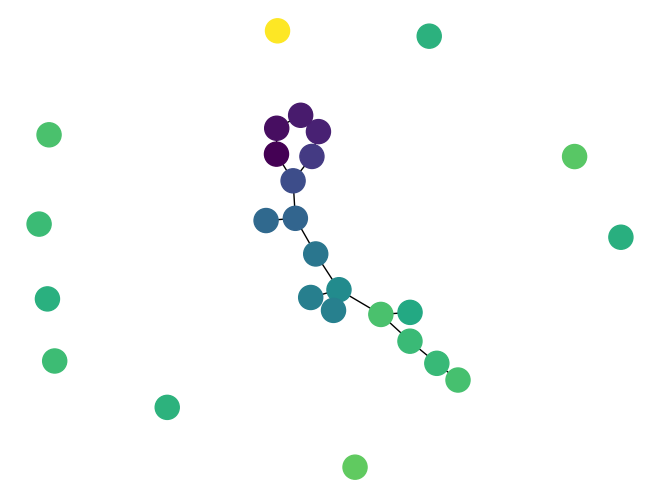

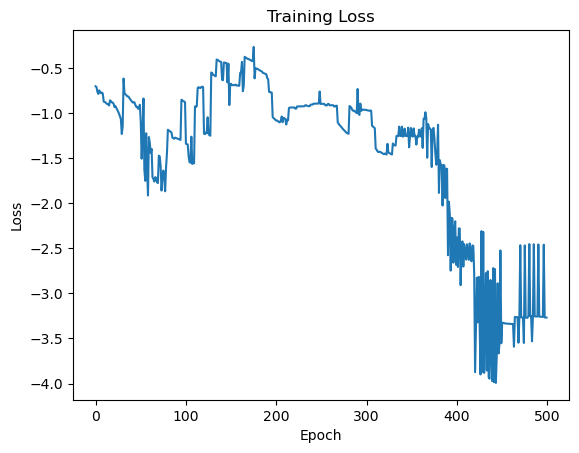

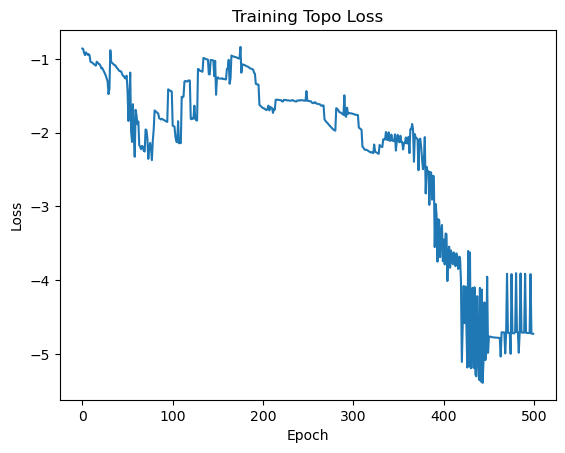

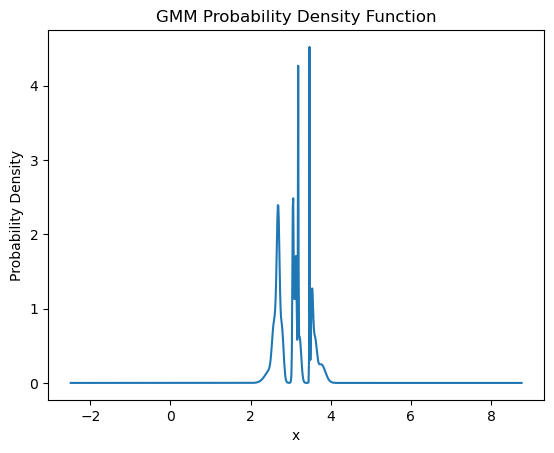

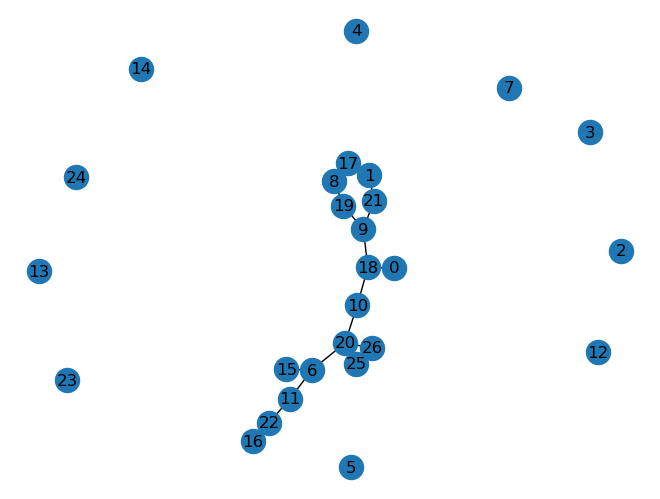

215


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


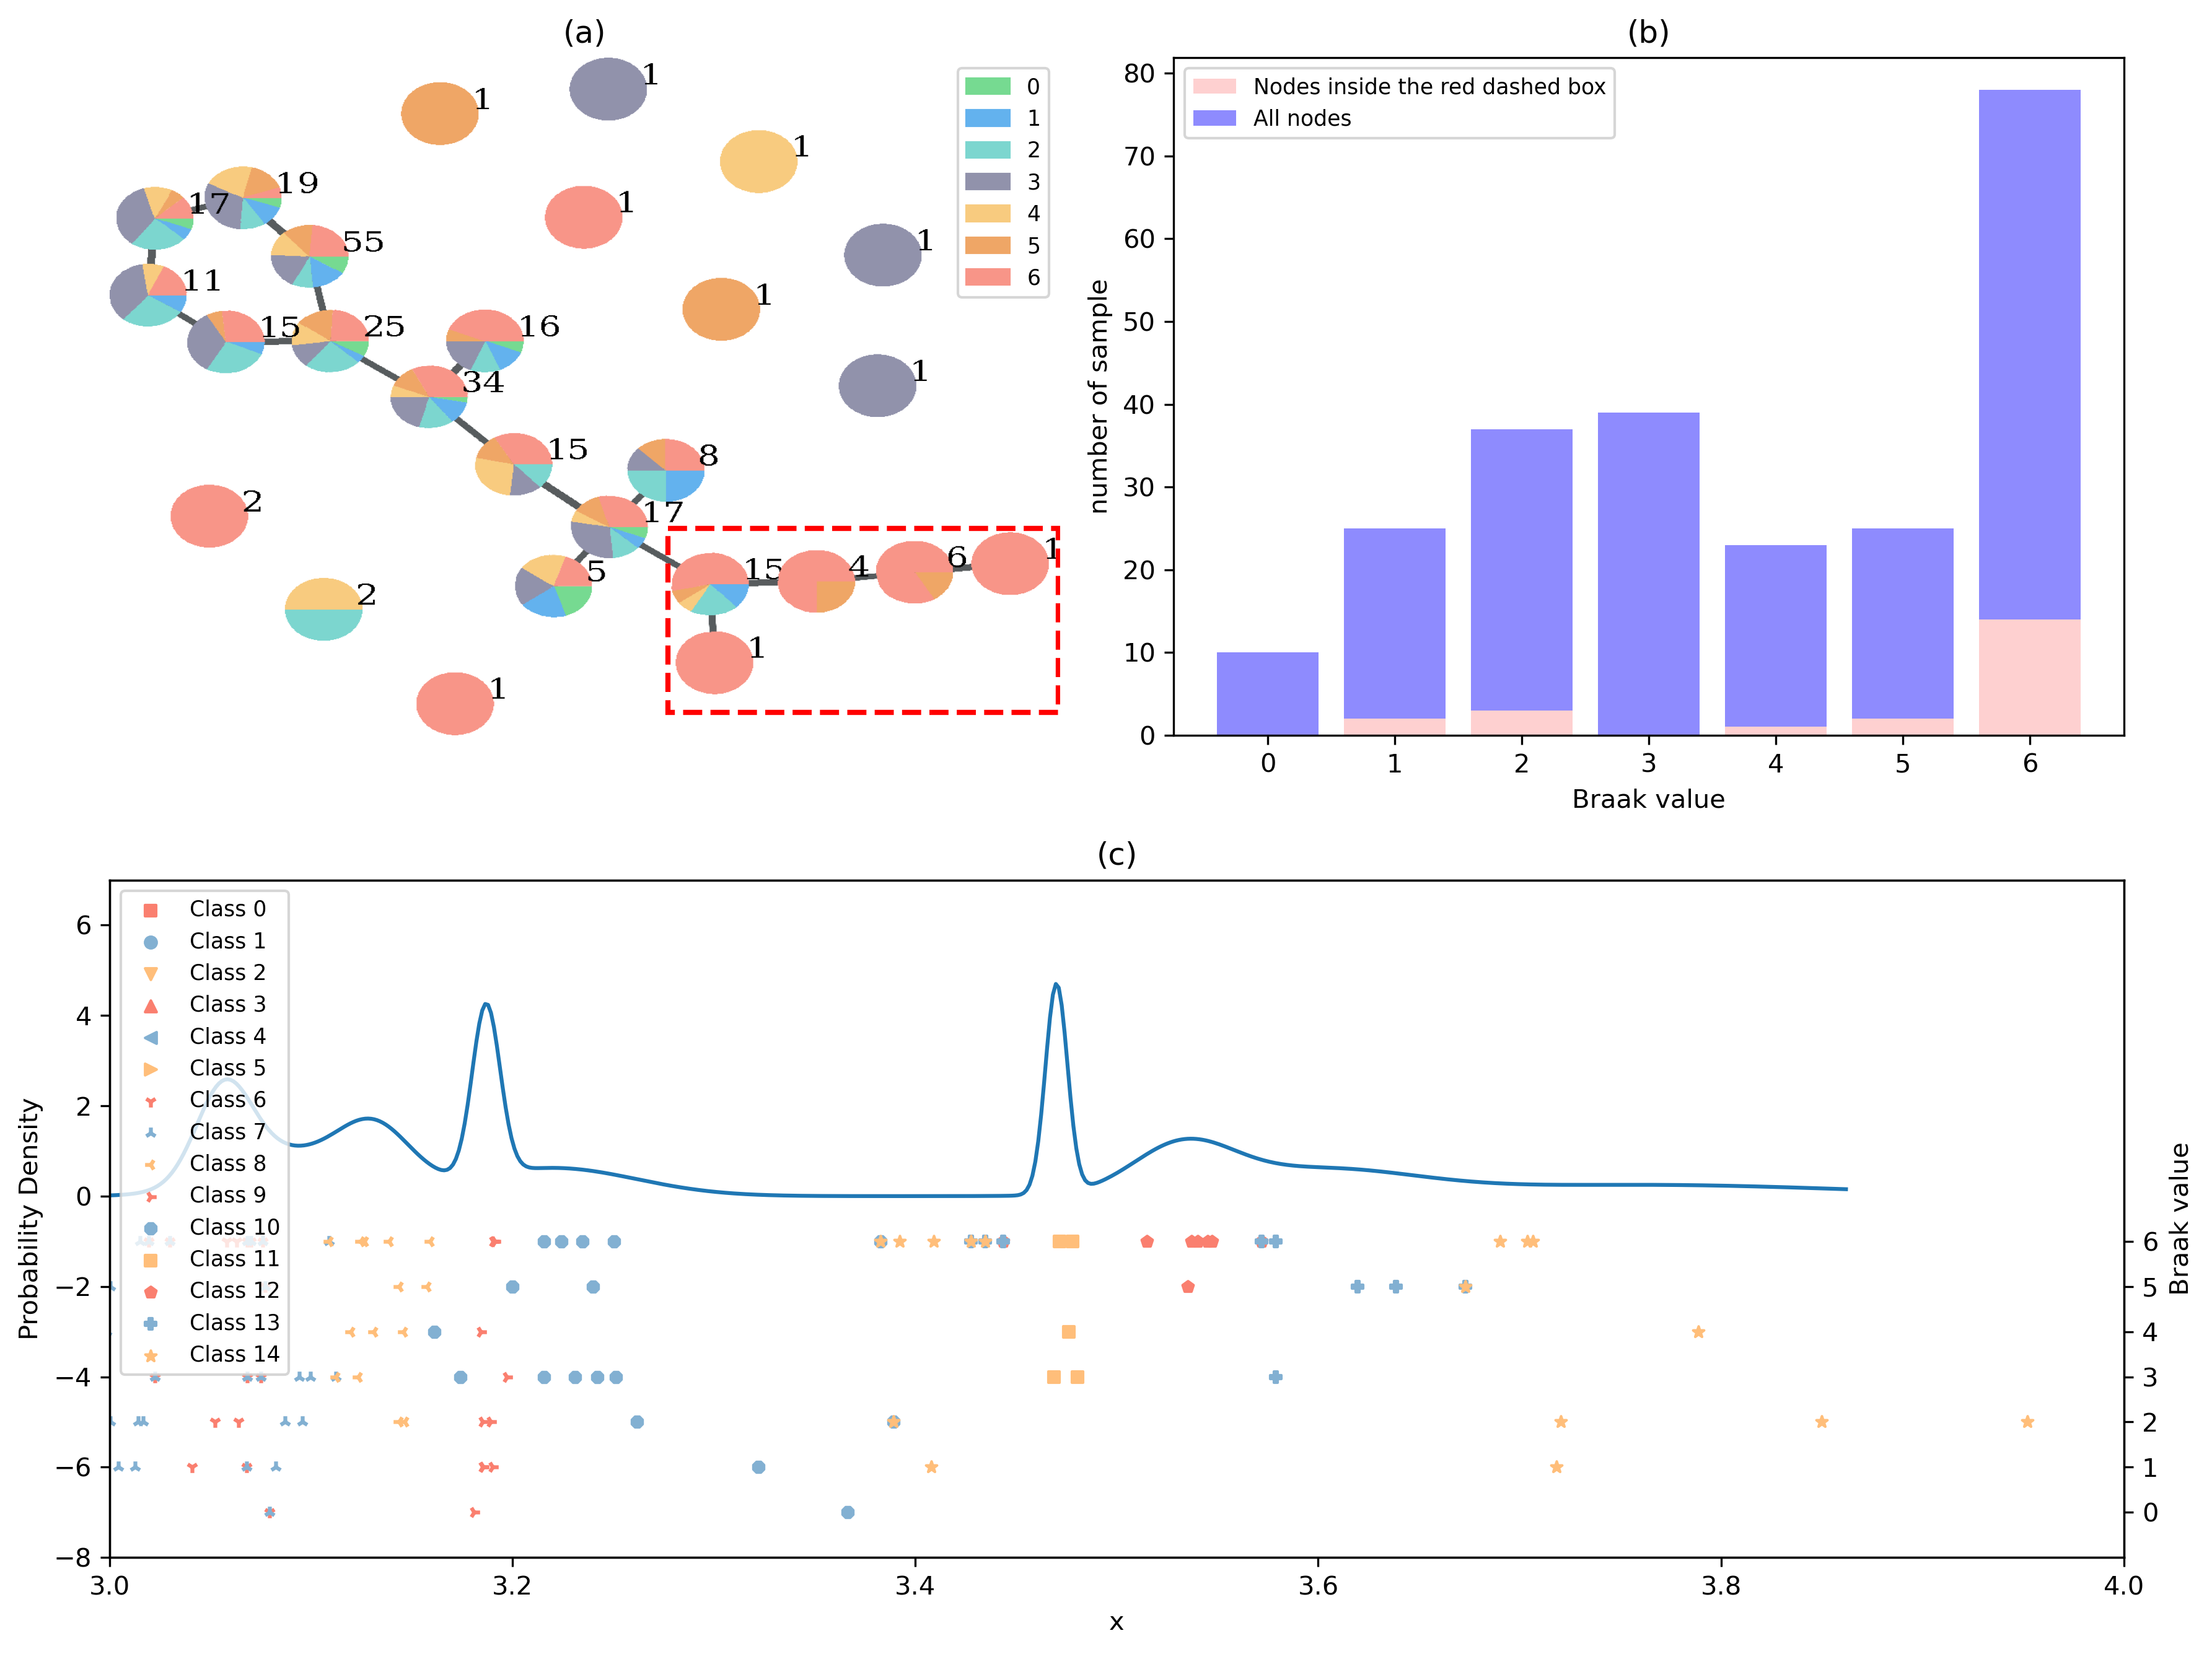

###########
Power_divergenceResult(statistic=18.695751989945542, pvalue=0.00470954013019232)
Have difference!!!


In [ ]:
data_path = "data/36_top_gene.csv"
df = pd.read_csv(data_path,index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)
dis_matrix = mean_lor_distance(data)
projected_data = dis_matrix.mean(dim = 0)
projected_data = projected_data.view(len(projected_data),1)

# GMM initialization
n_comp = 15 #20
num_step = 500 # 450 500
l1 = 1
l2 = 1


cl = AgglomerativeClustering(distance_threshold=3.13, linkage='single',
                        metric='precomputed', n_clusters=None)

gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-4,random_state = 0 )

gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures',name = 'MSBB_36',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.SGD(m.parameters(), lr=0.0001, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=450, gamma=0.1) #150

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
import networkx as nx
G_mode = train.G_mode
nx.draw(G_mode, with_labels=True)
plt.show()
clusters = train.mode_clusters

good_nodes = [11,15,16,6,22]

pos_list = [[ 3.03368299, -3.46388611], [-4.50585725, -4.72927214], [-3.13806622,  1.38346121], [11.82982347, -2.2245166 ], [  5.79949949, -10.42939218], [ 9.16797143, -8.42757858], 
            [8.07549389, 3.2618482 ], [-0.57541149,  3.96272112], [-2.38424855, -7.42230883], [-0.42753119, -3.46258944], [ 3.6761236 , -0.05294675], [10.46030098,  3.18812343], 
            [ 2.02884645, -9.75385544], [ 8.32857262, -4.33903805], [11.9512966 , -5.83826541], [8.1789573 , 5.43586192], [14.8,  2.7], [-4.35717844, -6.85529748], 
            [ 1.78430883, -1.91964732], [-0.88962258, -5.80291999], [5.82439687, 1.68073967], [-2.76986779, -3.43940053], [12.65556007,  2.9351866 ], [2.36575412, 6.57068134], 
            [ 5.24965958, -6.88746489], [4.57140821, 3.31315579], [7.08707343, 0.11847304]]
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (3,4),(-8, 7),
                pos_list=pos_list, rect_pos=(640,667,448,260)
                ,text_pos=[-0.3,-2.],name = "figures/36.eps")

215


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


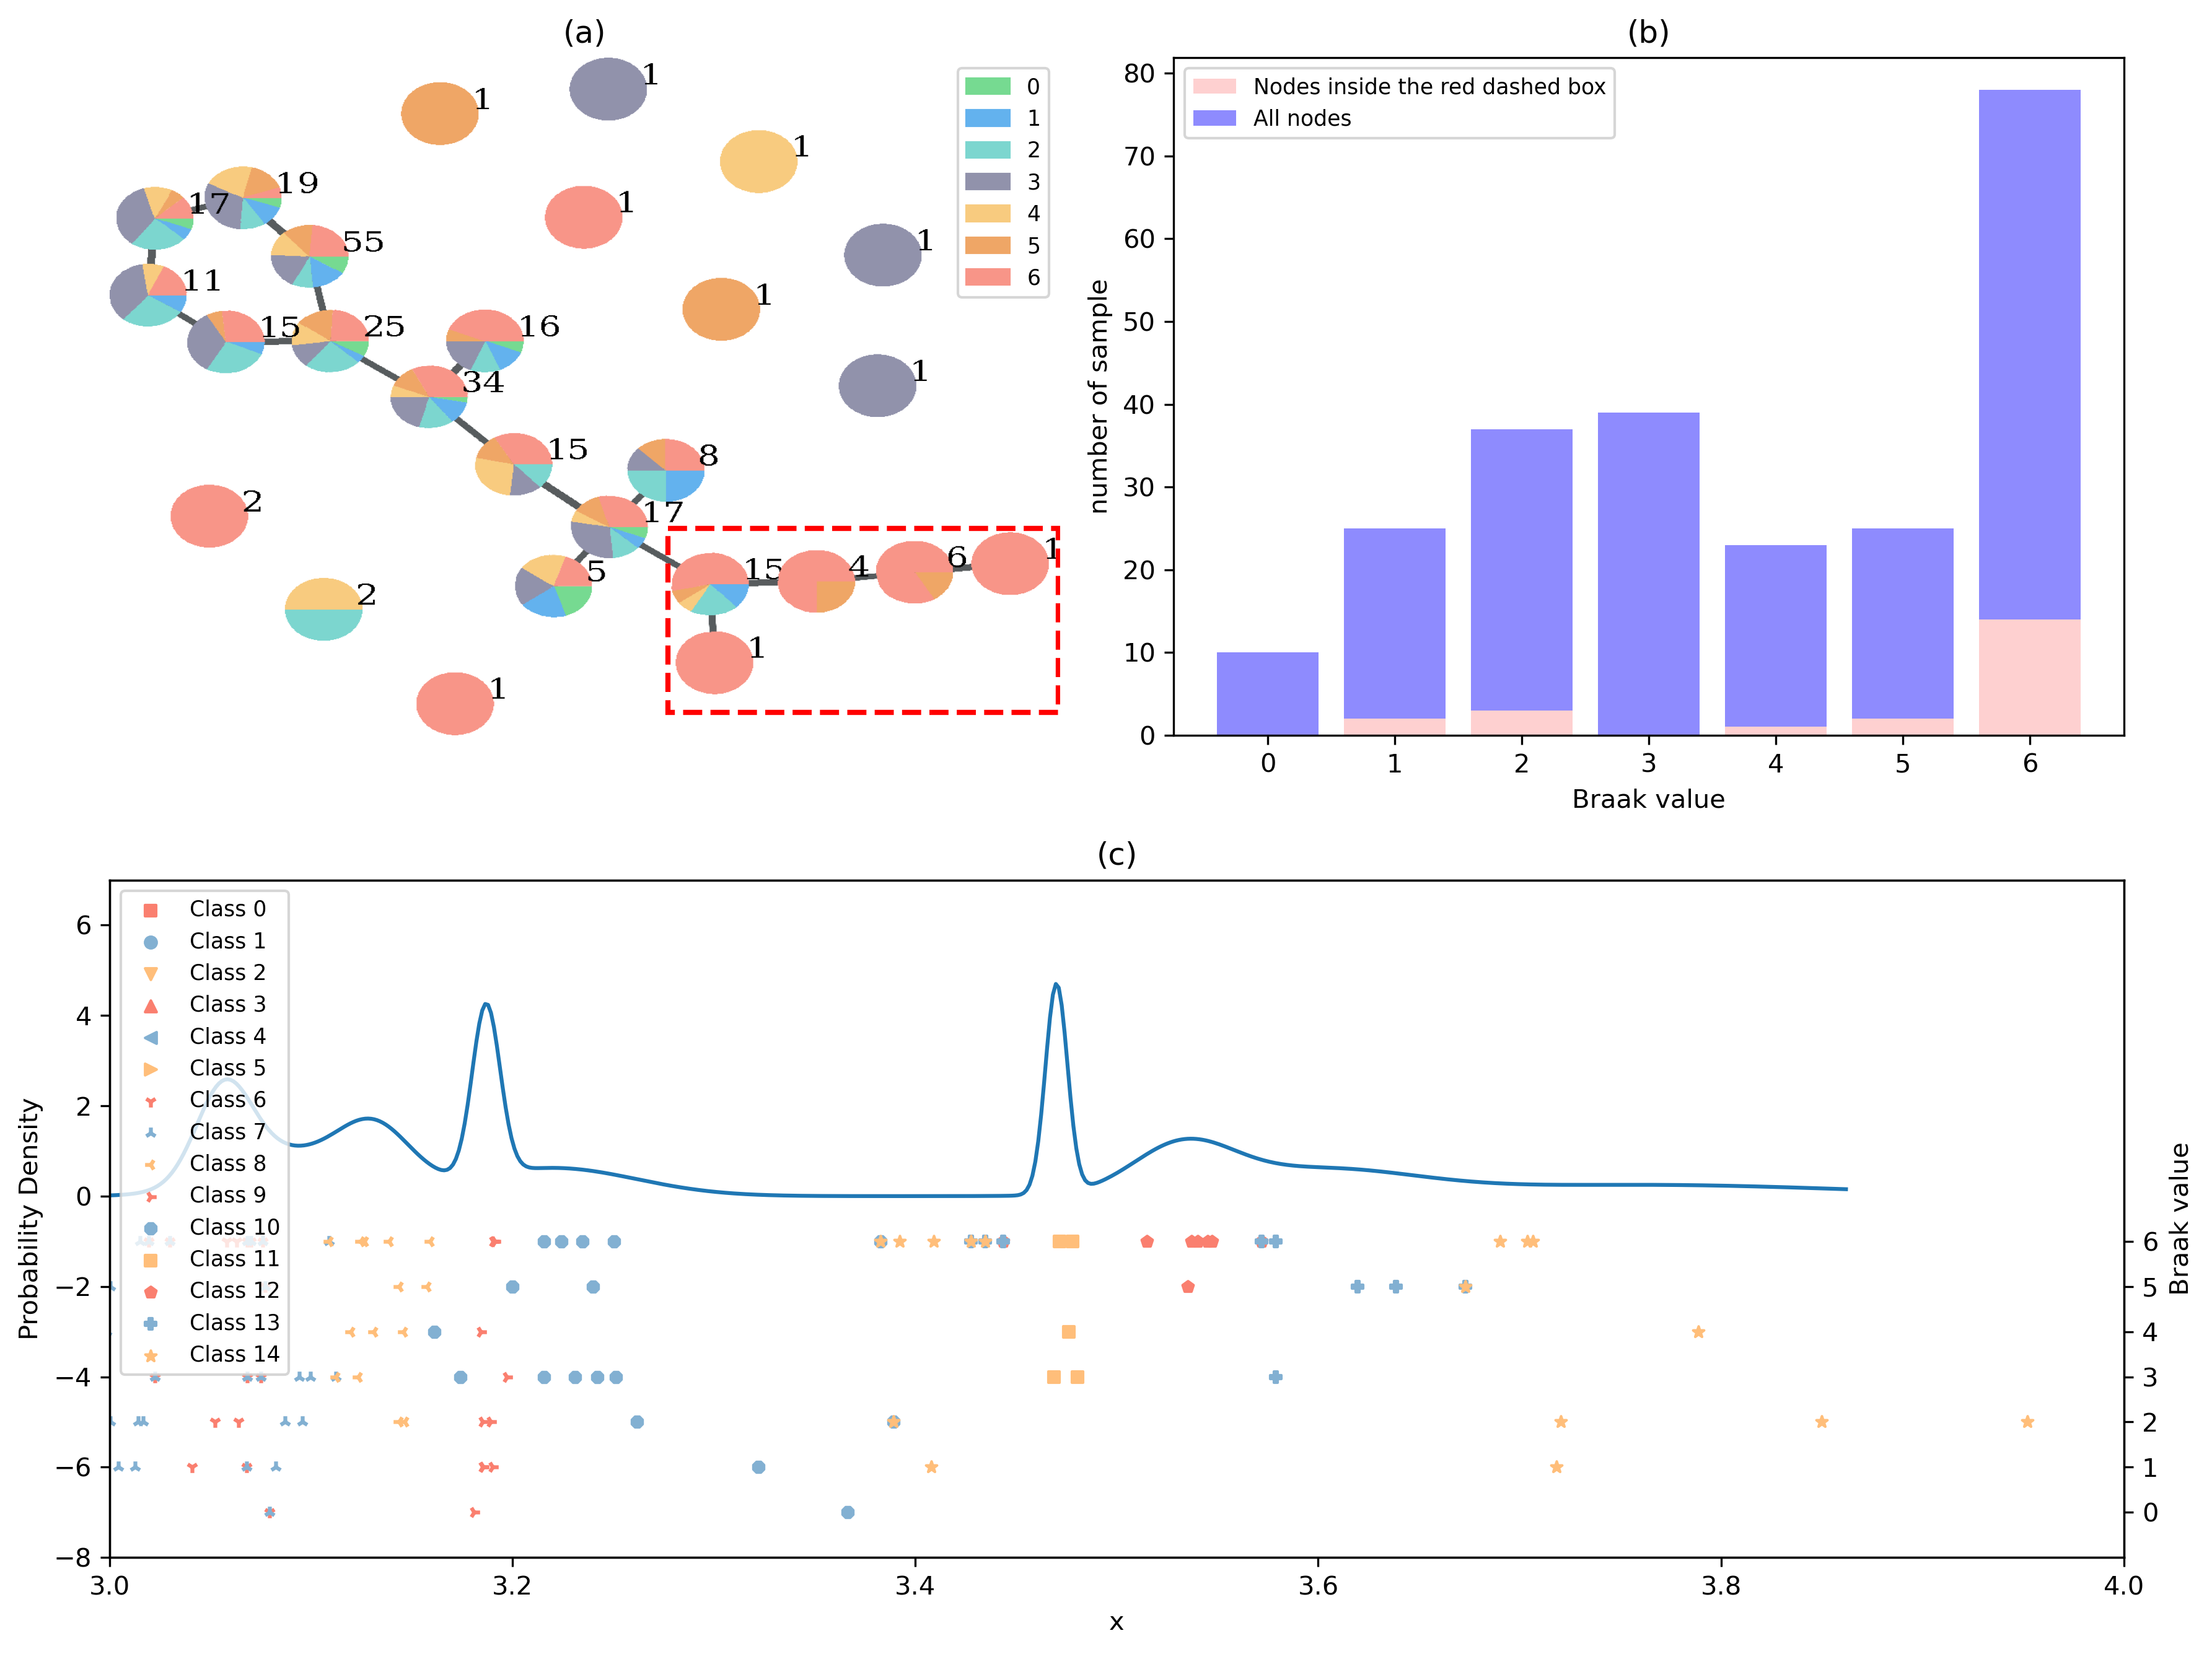

###########
Power_divergenceResult(statistic=18.695751989945542, pvalue=0.00470954013019232)
Have difference!!!


In [ ]:
pos_list = [[ 3.03368299, -3.46388611], [-4.50585725, -4.72927214], [-3.13806622,  1.38346121], [11.82982347, -2.2245166 ], [  5.79949949, -10.42939218], [ 9.16797143, -8.42757858], 
            [8.07549389, 3.2618482 ], [-0.57541149,  3.96272112], [-2.38424855, -7.42230883], [-0.42753119, -3.46258944], [ 3.6761236 , -0.05294675], [10.46030098,  3.18812343], 
            [ 2.02884645, -9.75385544], [ 8.32857262, -4.33903805], [11.9512966 , -5.83826541], [8.1789573 , 5.43586192], [14.8,  2.7], [-4.35717844, -6.85529748], 
            [ 1.78430883, -1.91964732], [-0.88962258, -5.80291999], [5.82439687, 1.68073967], [-2.76986779, -3.43940053], [12.65556007,  2.9351866 ], [2.36575412, 6.57068134], 
            [ 5.24965958, -6.88746489], [4.57140821, 3.31315579], [7.08707343, 0.11847304]]
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (3,4),(-8, 7),
                pos_list=pos_list, rect_pos=(640,667,448,260)
                ,text_pos=[-0.3,-2.],name = "figures/36.eps")

# 22

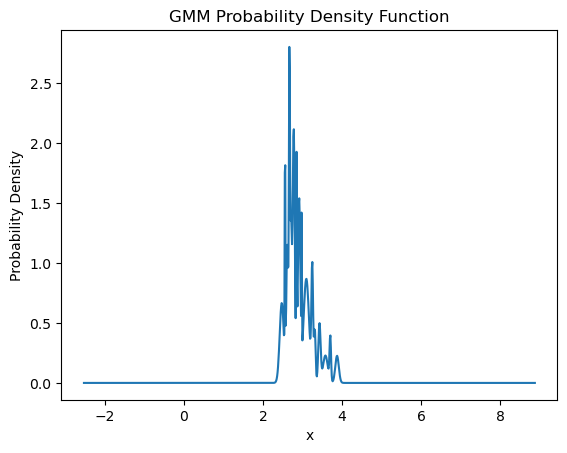

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


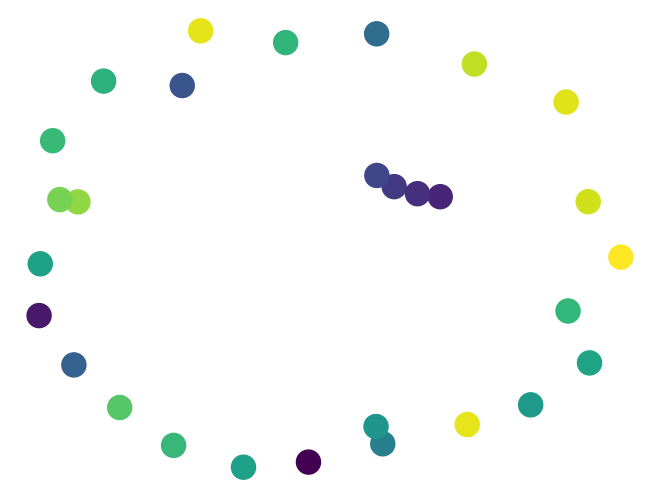

100%|██████████| 550/550 [00:13<00:00, 39.46it/s]


loss: -0.6153115901622968
topo_loss: -2.5152260117421905
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


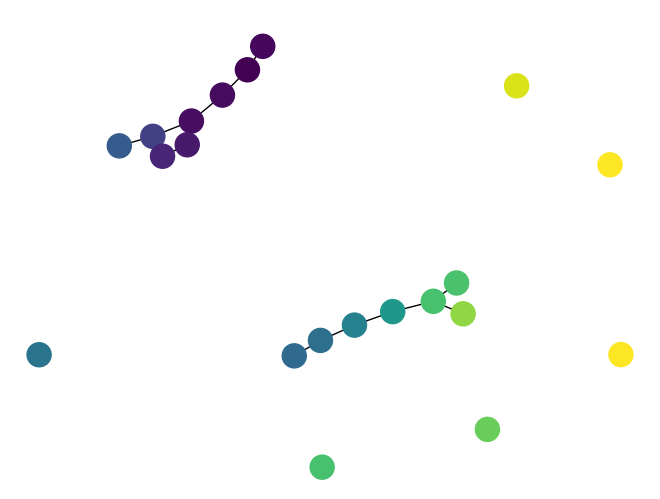

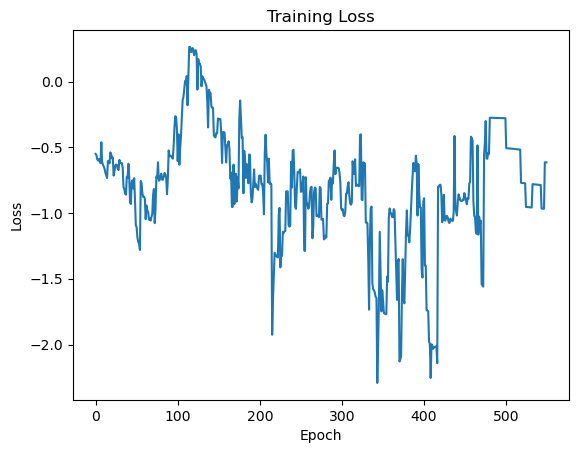

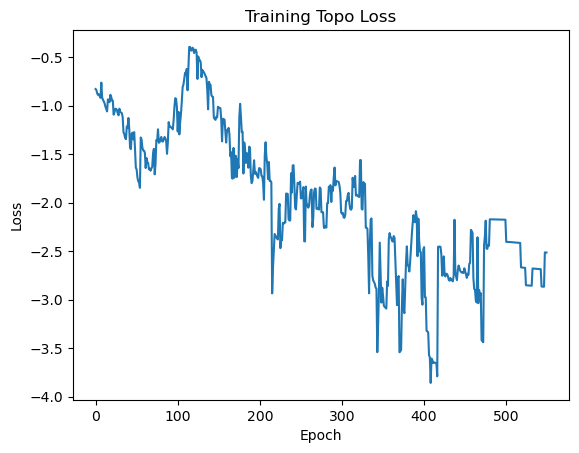

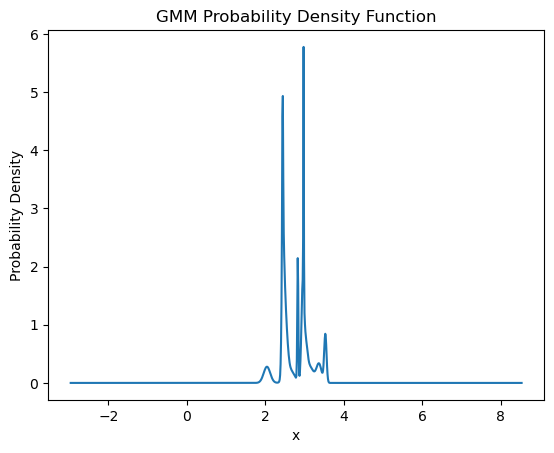

Vertex 0 position: [3.856376767391976, -0.17643275111543366]
Vertex 1 position: [7.861618059972026, 1.3148683419682903]
Vertex 2 position: [2.111555919853058, -2.297377554008081]
Vertex 3 position: [7.98388608636555, -2.8202047727461275]
Vertex 4 position: [10.489573200234457, 0.9127651975302546]
Vertex 5 position: [4.310114600188343, 4.666808623550169]
Vertex 6 position: [0.7290292655501209, 1.1623603305072105]
Vertex 7 position: [5.125781507515975, -5.534890416984884]
Vertex 8 position: [4.799901556352602, 2.289441930526913]
Vertex 9 position: [0.8209558500606124, -1.9808060353680532]
Vertex 10 position: [6.873720951102658, 4.564088157473337]
Vertex 11 position: [9.106625617696606, -3.5225415688639936]
Vertex 12 position: [6.974945751280512, -3.7187777582576778]
Vertex 13 position: [2.076442495834072, 3.3312026763025537]
Vertex 14 position: [7.993502702182409, -1.4055272359927187]
Vertex 15 position: [3.3726904044701556, -1.542586296545053]
Vertex 16 position: [3.8928578740977557, -2

IndexError: index 24 is out of bounds for dimension 0 with size 21

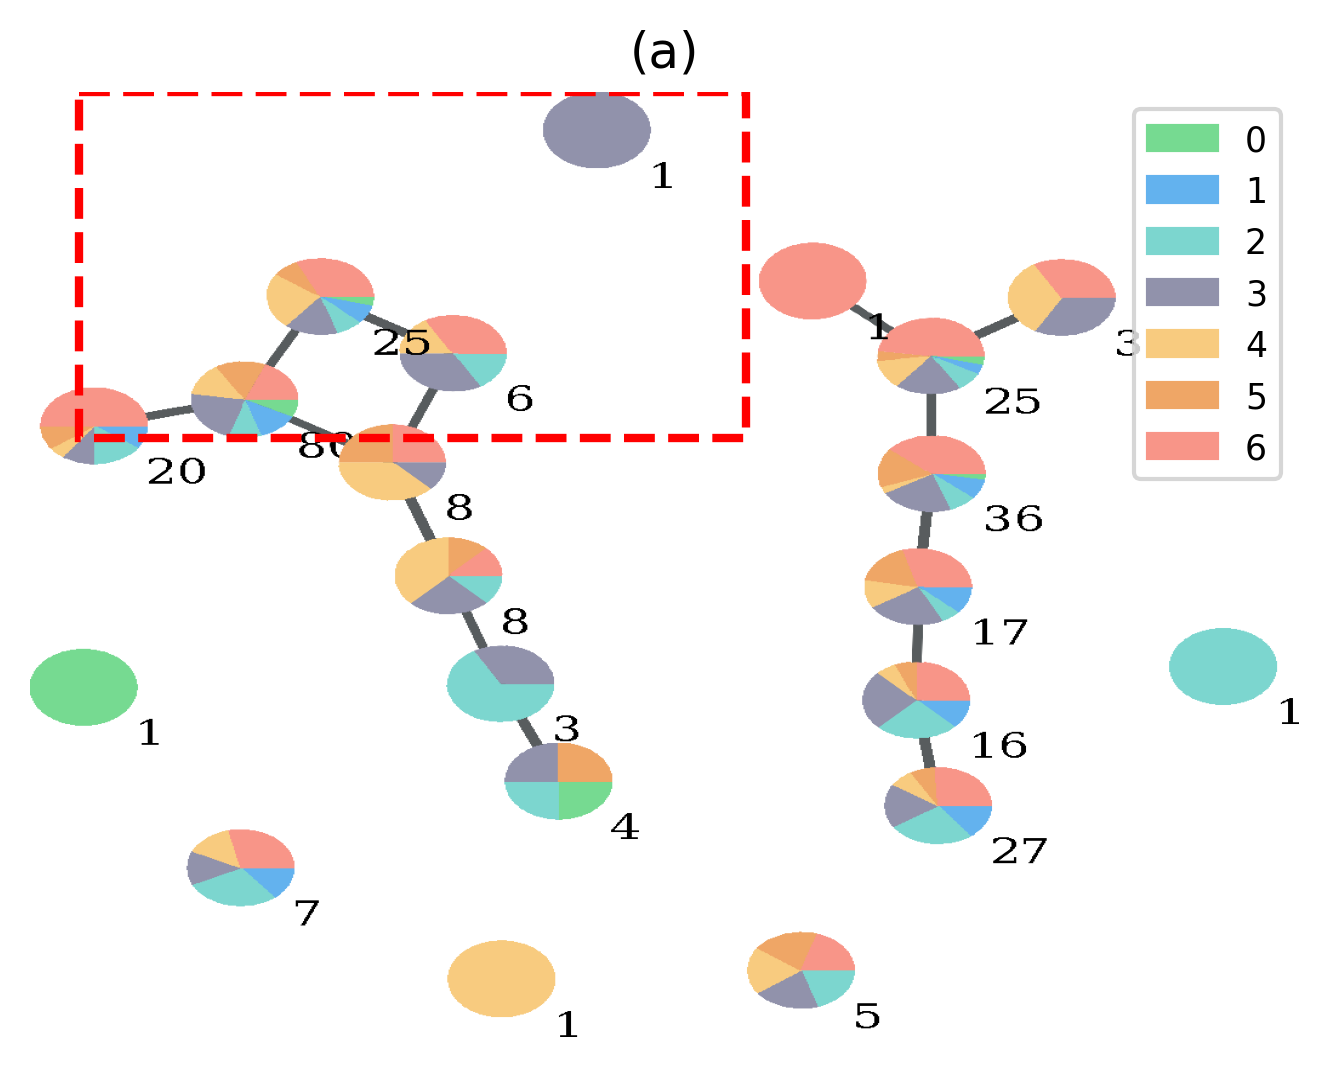

In [ ]:
data_path = "data/22_top_gene.csv"
df = pd.read_csv(data_path,index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)
dis_matrix = mean_lor_distance(data)
projected_data = dis_matrix.mean(dim = 0)
projected_data = projected_data.view(len(projected_data),1)

# GMM initialization
n_comp = 16
num_step = 550
l1 = 1
l2 = 1
#define clustering
cl = AgglomerativeClustering(distance_threshold=3.31, linkage='single',
                      metric='precomputed', n_clusters=None)
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-4,random_state = 0 )

gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures',name = 'MSBB_22',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=480, gamma=0.01) #600

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
pos_list = [[4.10355829, 3.39210388], [-3.83885787, -3.67247424], [-2.10920609,  5.59155466], 
 [7.27788535, 9.86003517], [14.48645461,  1.26016604], [6.42318617, 3.57881402], 
 [10.00353471, -4.00907635], [11.50760937, -7.61565784], [-5.15822097,  0.25580447], 
 [14.26108763, -1], [2.79145978, 9.88150941], [10.96019372,  7.18690422], 
 [0, 0.5], [ 7.07646524, -2.54620117], [ 2.01476486, -9.43542304], 
 [12.31703462,  5.61936283], [ 7.7566697 , -9.35280568], [ 1.96227198, -7.19066268], 
 [-0.93638095, 8.5], [5.14550871, 6], [7.23655926, 1.3435164 ], 
 [-1.96164343, -4.66672683], [-2, 3], [12.51570059,  0.54673731], 
 [ 0.2, -6], [4.5, -6.60649434], [3.25332704, 1.03645839], 
 [ 5.44370653, -0.31095776]]

G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [24,25,14,17,21,1] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (2.25,4),(-8, 7),
                pos_list= None, rect_pos=(40,0,550,400)
                ,text_pos=[-0.1,-0.3],name = "figures/22.eps")

# 10

In [ ]:
data_path = "data/10_top_gene.csv"
df = pd.read_csv(data_path,index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)
dis_matrix = mean_lor_distance(data)
projected_data = dis_matrix.mean(dim = 0)
projected_data = projected_data.view(len(projected_data),1)

plt.scatter(projected_data,[0]*len(projected_data))
plt.show()

# GMM initialization
n_comp = 12
num_step = 700
l1 = 1
l2 = 1
cl = AgglomerativeClustering(distance_threshold=3.06, linkage='single',
                           metric='precomputed', n_clusters=None)
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-4,random_state = 0 )

gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights , type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures',name = 'MSBB_10',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

#optimizer
optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 610, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
pos_list = [[10.69418452,  9], [8.37485216, 4.76298667], [ 3.453978 , -4.1383851], 
 [-0.10956041, -1.20912517], [-2.94900493,  7.16660087], [13.23744596,  3.21028077], 
 [ 6.58932505, -4.98731586], [3.24306977, 0.66307753], [11.04887789, -3.16204578], 
 [ 1.80303796, 11.17330993], [4.01152143, 2.58062852], [1.99194245, 2.93809174], 
 [ 0.09850215, -4.46641321], [6.19858406, 8.91436344], [9.30092472, 0.29422501], 
 [ 6.66334149, -0.2176433 ], [-2.74084612,  2.84888045], [6.18949122, 4.03499077], 
 [10.19083048,  5.54441487], [7.4494094 , 1.67343696], [6.25159925, 6.68273608], 
 [ 6.18245919, 10.88242695], [-1.43855693,  3.92217574], [-1.50158575,  8.13062068], 
 [4.43131022, 5.15832172], [10.49369904, -1.39048887], [10, 11], 
 [1.69070937, 9.42518497]]

G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [1,18,20,13,21,14,25,8] 
rect_list = [(540,670,120,380),(675,540,220,200),(730,90,230,330)]
analysis_braak(G_mode, train, data_path, projected_data, good_nodes,(2.25,4.2),(-8, 6)
               , pos_list=None, rect_pos=rect_list
               ,text_pos=[-0.1,-0.3],name = "figures/10.eps")